Question: Does HPD keep data on traffic crashes?

Also, do we want to request the raw data that HPD submits to the state? It also contains locations of stops which is something that is not made publicly available. It would be interesting to see where most stops are made. I previously FOIA'ed this info for FCPD from the Virginia State Police. It only cost me $35. FCPD now puts their submitted spreadsheets on their website.

How does their data collection syste work? Is date automatically logged? What about time (even though not required by VCPA)? Can they start tracking times?

In [1]:
import sys
import os
import pandas as pd
from pylis import code

module_path = os.path.abspath(os.path.join('../..', "openpolicedata"))
if module_path not in sys.path:
    sys.path.append(module_path)

import openpolicedata as opd
import numpy as np

pd.set_option('display.max_colwidth',100)


In [2]:
import numpy as np

def section_num_to_title(sect_num):
    try:
        h = code.get_section_details(sect_num)
    except:
        return None
    if len(h['ChapterList'])>0:
        return h['ChapterList'][0]['SectionTitle']
    else:
        return None

def to_percent(x):
    return np.round(x/x.sum()*100,1)

In [3]:
src = opd.Source("Virginia")
data = src.load_from_url(year=[2020,2030], agency="Herndon Police Department")
df = data.table

len(df)

15848

In [4]:
def add_cols(df):
    df["year"] = df["incident_date"].dt.year
    df["month"] = df["incident_date"].dt.to_period("M")
    df["quarter"] = df["incident_date"].dt.to_period("Q")

    df["race_eth"] = df["race"].copy()
    df.loc[df["ethnicity"] == "HISPANIC OR LATINO", "race_eth"] = "HISPANIC OR LATINO"
    df.loc[df["ethnicity"] == "UNKNOWN", "race_eth"] = "UNKNOWN"

    df["age_range"] = pd.cut(df["age"].astype(int),[-1,15,25,35,45,55,65, 200],labels=["0-15","16-25","26-35","36-45","46-55","56-65","65+"])

add_cols(df)
map = {x : section_num_to_title(x) for x in df["specific_violation"].unique()}
df["section_title"] = df["specific_violation"].map(map)
df["section_title"].head()

tv = df[df["reason_for_stop"]=="TRAFFIC VIOLATION"]
tv.reset_index(inplace=True)

print("Total traffic violations by race and ethnicity since VCPA start")
tv["race_eth"].value_counts()

Total traffic violations by race and ethnicity since VCPA start


WHITE                                                 6505
HISPANIC OR LATINO                                    4039
BLACK OR AFRICAN AMERICAN                             2483
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER    1105
UNKNOWN                                                342
AMERICAN INDIAN OR ALASKA NATIVE                       122
Name: race_eth, dtype: int64

What is spike in Early 2022?
Stops for traffic violations are actually lower than previous years after that


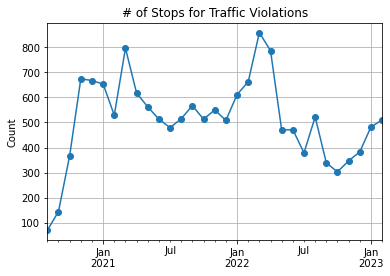

In [5]:
tv_by_month = df.groupby(["month"]).size()
ax = tv_by_month.plot(grid=True, xlabel="",ylabel="Count", title="# of Stops for Traffic Violations",marker="o")

print("What is spike in Early 2022?")
print("Stops for traffic violations are actually lower than previous years after that")

The highest increase in stops for traffic violations by count (not %) involves White individuals


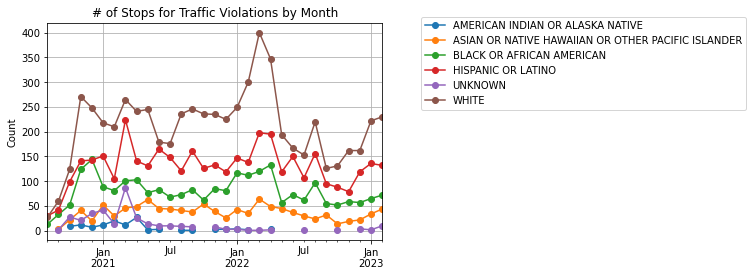

In [6]:
tv_by_month = tv.groupby(["month","race_eth"]).size().unstack("race_eth")
ax = tv_by_month.plot(grid=True, xlabel="",ylabel="Count", title="# of Stops for Traffic Violations by Month",marker="o")
ax.legend(bbox_to_anchor=(1.1, 1.05))

print("The highest increase in stops for traffic violations by count (not %) involves White individuals")

In [7]:
high_month = "Mar 2022"

tv_2021 = tv[tv["incident_date"].dt.year == 2021]
df_high = tv[tv["month"]==high_month]

tv_2021 = tv_2021["race_eth"].value_counts() / 12
tv_2021.name = "2021 Average Month"
df_high = df_high["race_eth"].value_counts()
df_high.name = high_month
df_high = pd.concat([tv_2021, df_high],axis=1).round(1).fillna(0).convert_dtypes()
df_high["% Difference"] = round((df_high[high_month] - df_high["2021 Average Month"]) / df_high["2021 Average Month"] * 100,1)

print("Increase in traffic violatins affected Whites the greatest")
df_high


Increase in traffic violatins affected Whites the greatest


,2021 Average Month,Mar 2022,% Difference
WHITE,226.0,400,77.0
HISPANIC OR LATINO,143.8,198,37.7
BLACK OR AFRICAN AMERICAN,82.2,120,46.0
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,43.9,64,45.8
UNKNOWN,19.2,1,-94.8
AMERICAN INDIAN OR ALASKA NATIVE,7.0,0,-100.0


In [8]:
tv_2021 = tv[tv["incident_date"].dt.year == 2021]
tv_2022 = tv[tv["incident_date"].dt.year == 2022]

tv_2021 = tv_2021["race_eth"].value_counts() / 12
tv_2021.name = "2021 Average Month"
tv_2022 = tv_2022["race_eth"].value_counts() / 12
tv_2022.name = "2022 Average Month"
df_high = pd.concat([tv_2021, tv_2022],axis=1).round(1).fillna(0).convert_dtypes()
df_high["% Difference"] = round((df_high["2022 Average Month"] - df_high["2021 Average Month"]) / df_high["2021 Average Month"] * 100,1)

print("Overall stops for traffic violations were down slightly except for Black individuals which stayed the same")
df_high


Overall stops for traffic violations were down slightly except for Black individuals which stayed the same


,2021 Average Month,2022 Average Month,% Difference
WHITE,226.0,217.6,-3.7
HISPANIC OR LATINO,143.8,132.6,-7.8
BLACK OR AFRICAN AMERICAN,82.2,82.8,0.7
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,43.9,34.5,-21.4
UNKNOWN,19.2,1.1,-94.3
AMERICAN INDIAN OR ALASKA NATIVE,7.0,0.8,-88.6


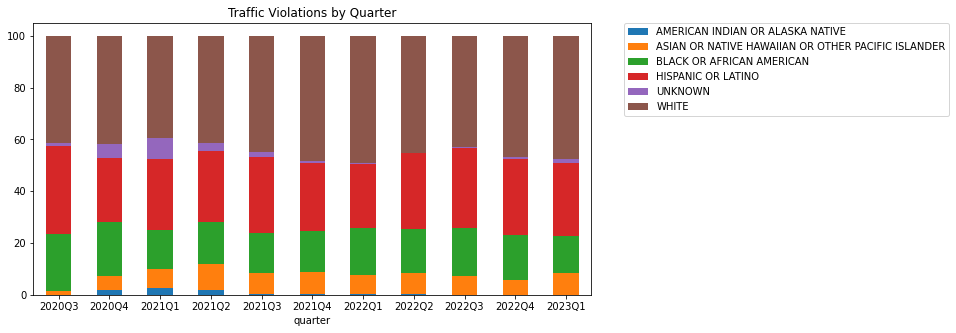

In [9]:
residency = None#"OTHER VIRGINIA JURISDICTION RESIDENT" #"RESIDENT OF CITY/COUNTY OF STOP"#
group = tv.copy()
if residency is not None:
    group = group[group["residency"]==residency]
group = group.groupby(["quarter", "race_eth"]).size().unstack("race_eth").fillna(0)
group = group.div(group.sum(axis=1), axis=0)*100
ax = group.plot.bar(stacked=True, figsize=[10,5], rot=0, title="Traffic Violations by Quarter")
ax.legend(bbox_to_anchor=(1.05, 1.02))


Black individuals are stopped at about twice their population (consistent with last year). Is there anything that is different about Black stops? (age, violation type, etc.)


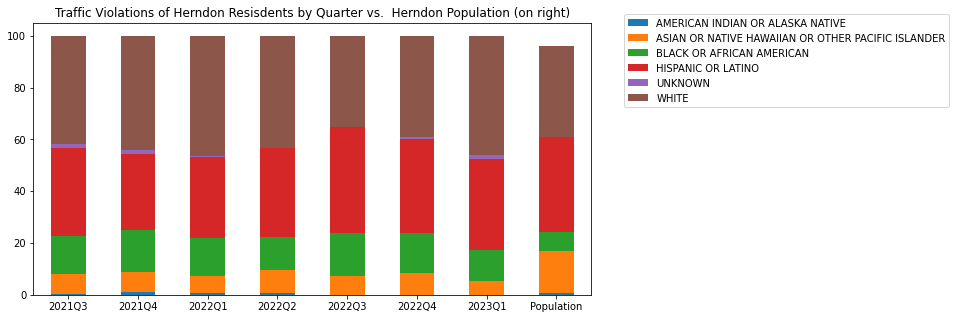

In [10]:
residency = "RESIDENT OF CITY/COUNTY OF STOP"
group = tv.copy()
if residency is not None:
    group = group[group["residency"]==residency]
group = group.groupby(["quarter", "race_eth"]).size().unstack("race_eth").fillna(0)
group = group.div(group.sum(axis=1), axis=0)*100

# Population percentages from https://www.census.gov/quickfacts/fact/table/herndontownvirginia/PST045222 for Population Estimates, July 1, 2022, (V2022)

pop_perc = [0.8, 16.1, 7.3, 36.7,np.nan,35.4]
d = {x:y for x,y in zip(group.columns, pop_perc)}
pops = pd.Series(d, name="Population")
group = pd.concat([group,pd.DataFrame(pops).transpose()],axis=0)

ax = group.plot.bar(stacked=True, figsize=[10,5], rot=0, title="Traffic Violations of Herndon Resisdents by Quarter vs.  Herndon Population (on right)")
ax.legend(bbox_to_anchor=(1.05, 1.05))

print("Black individuals are stopped at about twice their population (consistent with last year). Is there anything that is different about Black stops? (age, violation type, etc.)")

In [112]:
year = 2022
tv_res = tv[tv["residency"]=="RESIDENT OF CITY/COUNTY OF STOP"]
tv_res = tv_res[tv_res["year"]==year]
total_pop = 24339

pop_counts = round(pops/100 * total_pop)

num_stops = tv_res["race_eth"].value_counts()
stops_per_1000_people = round(num_stops / pop_counts * 1000,1)

print(f"Stops of residents per 1000 people for {year}")
people = pop_counts["BLACK OR AFRICAN AMERICAN"]
num = num_stops["BLACK OR AFRICAN AMERICAN"]
rate = stops_per_1000_people["BLACK OR AFRICAN AMERICAN"]
print(f"Black Herndon residents were stopped {rate} times per 1000 people in {year} based on {num} stops out of {people} people")
stops_per_1000_people

Stops of residents per 1000 people for 2022
Black Herndon residents were stopped 157.6 times per 1000 people in 2022 based on 280 stops out of 1777.0 people


AMERICAN INDIAN OR ALASKA NATIVE                       35.9
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER     37.8
BLACK OR AFRICAN AMERICAN                             157.6
HISPANIC OR LATINO                                     74.6
UNKNOWN                                                 NaN
WHITE                                                  93.8
dtype: float64

What is increase in early 2022 in equipment violations?
Terry stops remain low


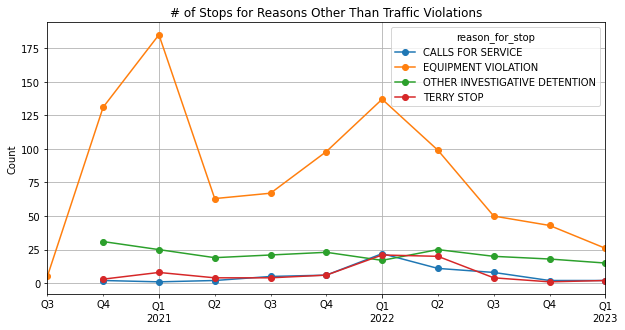

In [11]:
tv_by_month = df.groupby(["quarter","reason_for_stop"]).size().unstack("reason_for_stop")
ax = tv_by_month.drop(columns="TRAFFIC VIOLATION").plot(grid=True, xlabel="",ylabel="Count", figsize=[10,5],
                                                        title="# of Stops for Reasons Other Than Traffic Violations",marker="o")
# ax.legend(bbox_to_anchor=(1.1, 1.05))
print("What is increase in early 2022 in equipment violations?")
print("Terry stops remain low")

Looks like increase in Equipment Violations affects Whites most


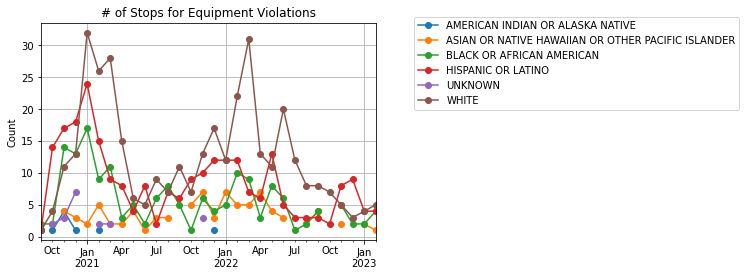

In [12]:
tv_by_month = df[df["reason_for_stop"]=="EQUIPMENT VIOLATION"].groupby(["month","race_eth"]).size().unstack("race_eth")
ax = tv_by_month.plot(grid=True, xlabel="",ylabel="Count", title="# of Stops for Equipment Violations",marker="o")
ax.legend(bbox_to_anchor=(1.1, 1.05))
print("Looks like increase in Equipment Violations affects Whites most")

In [13]:
low_month = "Oct 2021"
high_month = "Mar 2022"
df_ev = df[df["reason_for_stop"]=="EQUIPMENT VIOLATION"]
df_ev = df_ev[(df_ev["month"]==high_month) | (df_ev["month"]==low_month)]
df_ev = df_ev.groupby(["specific_violation","month"]).size().unstack("month").fillna(0).convert_dtypes()

# df_ev = pd.DataFrame(df_ev)
df_ev = df_ev.sort_values(high_month, ascending=False)
df_ev["Description"] = [map[x] for x in df_ev.index]

print(f"Shown are the top violations for equipment violations in {high_month}\n")
print(f"{high_month} is an example of a month where equipment violations were highest")
print(f"{low_month} is an example of a month where equipment violations were lowest\n")
print("Increase in equipment violations is due to high numbers of:")
print("\t1. Vehicle registration expirations")
print("\t2. Safety inspection expirations\n")
print("I guess this was a focus in early 2022. Unsure why this would mainly affect White individuals")
df_ev.head()

Shown are the top violations for equipment violations in Mar 2022

Mar 2022 is an example of a month where equipment violations were highest
Oct 2021 is an example of a month where equipment violations were lowest

Increase in equipment violations is due to high numbers of:
	1. Vehicle registration expirations
	2. Safety inspection expirations

I guess this was a focus in early 2022. Unsure why this would mainly affect White individuals


month,2021-10,2022-03,Description
specific_violation,,,
46.2-646,7,24,Expiration and renewal of registration
46.2-1158,4,9,Frequency of inspection; scope of inspection
46.2-1030,7,8,When lights to be lighted; number of lights to be lighted at any time; use of warning lights
46.2-613,0,4,"Infractions relating to registration, licensing, and certificates of title; penalties"
42-9,0,1,None


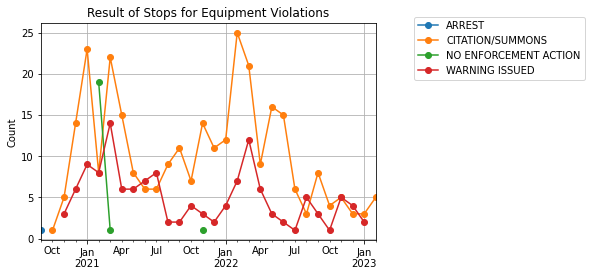

In [14]:
df_ev = df[df["reason_for_stop"]=="EQUIPMENT VIOLATION"]
df_ev = df_ev[df_ev["specific_violation"].apply(lambda x: x in ["46.2-646", "46.2-1158"] if pd.notnull(x) else False)]

df_ev = df_ev.groupby(["month","action_taken"]).size().unstack("action_taken")
ax = df_ev.plot(grid=True, xlabel="",ylabel="Count", marker="o",title="Result of Stops for Equipment Violations")
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [15]:
low_month = "Oct 2021"
high_month = "Mar 2022"
df_ev = df[df["reason_for_stop"]=="EQUIPMENT VIOLATION"]
df_ev = df_ev[df_ev["specific_violation"].apply(lambda x: x in ["46.2-646", "46.2-1158"] if pd.notnull(x) else False)]
df_ev = df_ev[(df_ev["month"]==high_month) | (df_ev["month"]==low_month)]

df_ev["race_eth"].value_counts()
df_ev = df_ev.groupby(["race_eth","action_taken","month"]).size().unstack("month").fillna(0).convert_dtypes()

print("Looking at the registration and safety inspection violations by race and action taken also shows this mainly affected Whites")
df_ev

Looking at the registration and safety inspection violations by race and action taken also shows this mainly affected Whites


month                                                                2021-10  \
race_eth                                           action_taken                
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER CITATION/SUMMONS        1   
                                                   WARNING ISSUED          2   
BLACK OR AFRICAN AMERICAN                          CITATION/SUMMONS        1   
                                                   WARNING ISSUED          0   
HISPANIC OR LATINO                                 CITATION/SUMMONS        2   
                                                   WARNING ISSUED          1   
WHITE                                              CITATION/SUMMONS        3   
                                                   WARNING ISSUED          1   

month                                                                2022-03  
race_eth                                           action_taken               
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER CITATION/SUMMONS        2  
                                                   WARNING ISSUED          1  
BLACK OR AFRICAN AMERICAN                          CITATION/SUMMONS        2  
                                                   WARNING ISSUED          4  
HISPANIC OR LATINO                                 CITATION/SUMMONS        0  
                                                   WARNING ISSUED          1  
WHITE                                              CITATION/SUMMONS       17  
                                                   WARNING ISSUED          6

In [16]:
high_month = "Mar 2022"
tv_2021 = tv[tv["incident_date"].dt.year == 2021]
df_high = tv[tv["month"]==high_month]

tv_2021 = tv_2021["specific_violation"].value_counts() / 12
tv_2021.name = "2021 Average Month"
df_high = df_high["specific_violation"].value_counts()
df_high.name = high_month
df_high = pd.concat([tv_2021, df_high],axis=1).round(1).fillna(0).convert_dtypes()
df_high["% Difference"] = round((df_high[high_month] - df_high["2021 Average Month"]) / df_high["2021 Average Month"] * 100,1)
df_high = df_high.sort_values(high_month, ascending=False)
df_high["Description"] = [map[x] for x in df_high.index]

print(f"Shown are the top violations for traffic violations in {high_month}\n")
print(f"{high_month} is an example of a month where equipment violations were highest")
print("Mostly big increases across the board")
df_high.head(10)

Shown are the top violations for traffic violations in Mar 2022

Mar 2022 is an example of a month where equipment violations were highest
Mostly big increases across the board


,2021 Average Month,Mar 2022,% Difference,Description
46.2-830,108.6,184,69.4,Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcemen...
46.2-874,39.4,89,125.9,Maximum speed limit in business and residence districts
46.2-818,28.8,76,163.9,Stopping vehicle of another; blocking access to premises; damaging or threatening commercial veh...
46.2-833,24.2,45,86.0,Traffic lights; penalty
46.2-646,33.8,38,12.4,Expiration and renewal of registration
46.2-1158,43.4,35,-19.4,Frequency of inspection; scope of inspection
46.2-875,19.1,30,57.1,Maximum speed limit on certain other highways in cities and towns
46.2-821,11.8,27,128.8,Vehicles before entering certain highways shall stop or yield right-of-way
46.2-715,6.3,26,312.7,Display of license plates
46.2-300,18.6,24,29.0,Driving without license prohibited; penalties


Early 2022 increase mainly in citations


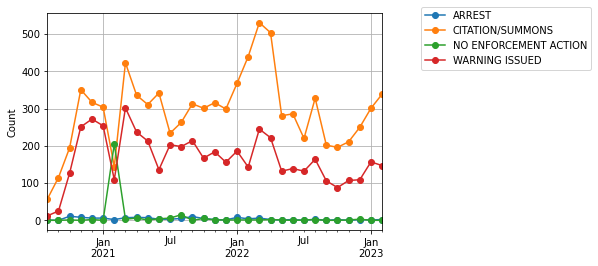

In [17]:
group = tv.groupby(["month", "action_taken"]).size().unstack("action_taken").fillna(0)

ax = group.plot(grid=True, xlabel="",ylabel="Count", marker="o")
ax.legend(bbox_to_anchor=(1.1, 1.05))

print("Early 2022 increase mainly in citations")

Increase in traffic violations was mainly non-Herndon residents.
It would seem that this was most likely due to whereve stops are being made


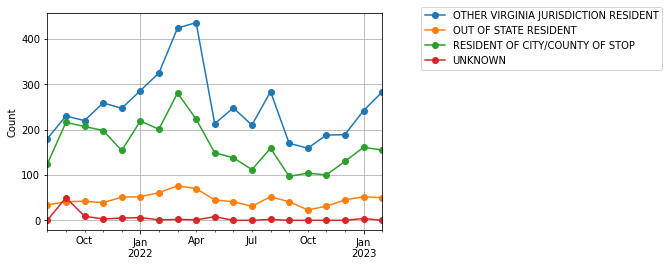

In [18]:
group = tv.groupby(["month", "residency"]).size().unstack("residency").fillna(0)

ax = group.plot(grid=True, xlabel="",ylabel="Count", marker="o")
ax.legend(bbox_to_anchor=(1.1, 1.05))

print("Increase in traffic violations was mainly non-Herndon residents.")
print("It would seem that this was most likely due to whereve stops are being made")


Percentage of stops ending in warnings went down in 2022


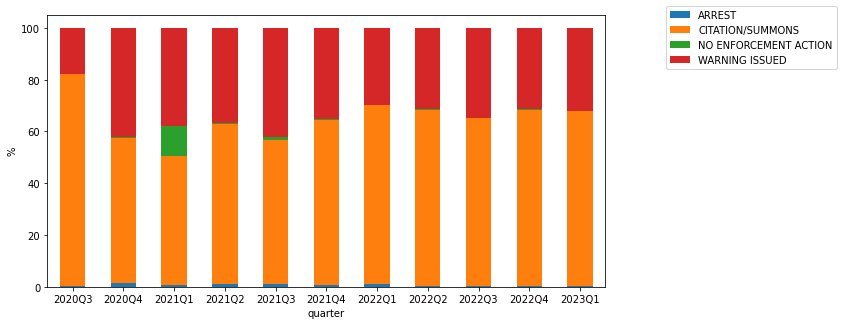

In [19]:
residency = None#"RESIDENT OF CITY/COUNTY OF STOP"#"OTHER VIRGINIA JURISDICTION RESIDENT" #
group = tv.copy()
if residency is not None:
    group = group[group["residency"]==residency]
group = group.groupby(["quarter", "action_taken"]).size().unstack("action_taken").fillna(0)
group = group.div(group.sum(axis=1), axis=0)*100
ax = group.plot.bar(stacked=True, figsize=[10,5], rot=0)
ax.set_ylabel("%")
ax.legend(bbox_to_anchor=(1.1, 1.05))

print("Percentage of stops ending in warnings went down in 2022")

In [20]:
df2 = None
for y in [2021,2022]:
    tv_year = tv[tv["incident_date"].dt.year == y]
    # tv_year = tv_year[tv_year["english_speaking"]=="YES"]
    tv_year = tv_year.groupby(["action_taken", "race_eth"]).size().fillna(0).unstack("race_eth")
    tv_year = tv_year.loc["WARNING ISSUED"] / tv_year.sum() * 100
    tv_year.name = y
    if df2 is None:
        df2 = tv_year
    else:
        df2 = pd.concat([df2,tv_year],axis=1)

df2 = df2.round(1)
df2["Diff"] = df2[2022] - df2[2021]

print("Comparison of % of traffic violations stops ending in warning")
print("Warning rate went down for Black, Whites, and Latinos")
df2

Comparison of % of traffic violations stops ending in warning
Warning rate went down for Black, Whites, and Latinos


,2021,2022,Diff
race_eth,,,
AMERICAN INDIAN OR ALASKA NATIVE,11.9,20.0,8.1
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,40.0,41.1,1.1
BLACK OR AFRICAN AMERICAN,45.1,36.0,-9.1
HISPANIC OR LATINO,40.1,33.1,-7.0
UNKNOWN,49.8,61.5,11.7
WHITE,33.2,27.1,-6.1


Most stops are people who don't live in TOH (see total column)
No evidence that they are more likely to cite people from out of town (such as out of state with different licenses)


action_taken,ARREST,CITATION/SUMMONS,NO ENFORCEMENT ACTION,WARNING ISSUED,Total
residency,,,,,
OTHER VIRGINIA JURISDICTION RESIDENT,0.6,70.2,0.3,29.0,4793
OUT OF STATE RESIDENT,0.3,56.2,0.3,43.1,877
RESIDENT OF CITY/COUNTY OF STOP,0.8,64.2,0.5,34.5,3128
UNKNOWN,1.1,24.2,0.0,74.7,91


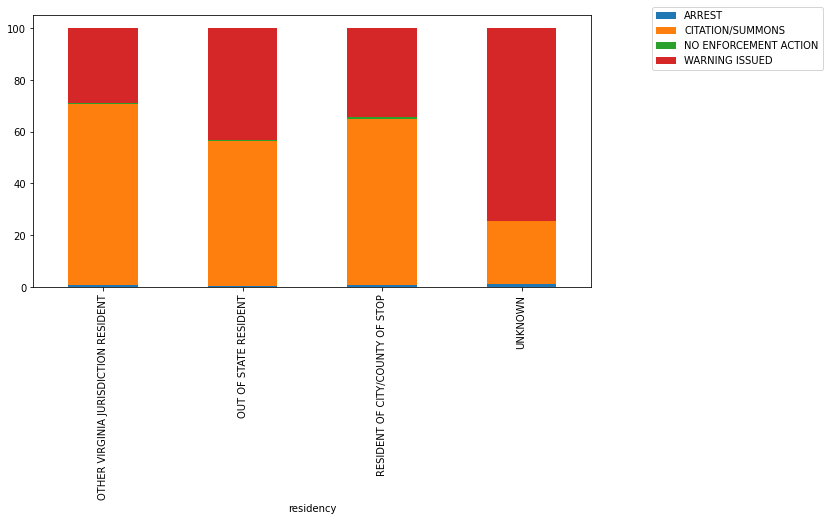

In [21]:
year = 2022
group = tv.copy()
if year is not None:
    group = group[group["year"]==year]
group = tv.groupby(["residency", "action_taken"]).size().unstack("action_taken").fillna(0)
total = group.sum(axis=1)
group = group.div(group.sum(axis=1), axis=0)*100
ax = group.plot.bar(stacked=True, figsize=[10,5])
ax.legend(bbox_to_anchor=(1.1, 1.05))
group["Total"] = total

print("Most stops are people who don't live in TOH (see total column)")
print("No evidence that they are more likely to cite people from out of town (such as out of state with different licenses)")
round(group.convert_dtypes(),1)


In [22]:
group = tv.groupby(["race_eth", "residency"]).size().unstack("residency").fillna(0).convert_dtypes()
print("Breakdown of traffic violations stops by race and residency")
round(group / group.sum() * 100,1)

Breakdown of traffic violations stops by race and residency


residency,OTHER VIRGINIA JURISDICTION RESIDENT,OUT OF STATE RESIDENT,RESIDENT OF CITY/COUNTY OF STOP,UNKNOWN
race_eth,,,,
AMERICAN INDIAN OR ALASKA NATIVE,0.1,0.0,0.4,0.0
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,7.7,7.2,7.5,12.1
BLACK OR AFRICAN AMERICAN,17.3,20.8,14.7,17.6
HISPANIC OR LATINO,23.5,33.2,33.8,19.8
UNKNOWN,0.4,0.7,0.7,1.1
WHITE,51.0,38.2,42.9,49.5


In [23]:
residency = None#"OTHER VIRGINIA JURISDICTION RESIDENT"# "RESIDENT OF TOWN/CITY/COUNTY OF STOP"

tmp = tv

if residency is not None:
    tmp = tmp[tmp["residency"]==residency]

new_df = pd.DataFrame()
for year in range(2020,2023):
    action_by_race = tmp[tmp["year"]==year].groupby(["action_taken","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()
    action_by_race = to_percent(action_by_race)
    action_by_race.index = pd.MultiIndex.from_product([action_by_race.index,[year]],names=[action_by_race.index.name,"year"])
    new_df = pd.concat([new_df, action_by_race])
    
print("Arrest rates during stops for traffic violations by year")
print("Arrest rates during stops for traffic violations remain low")
new_df = new_df.sort_index()
new_df.loc["ARREST"]

Arrest rates during stops for traffic violations by year
Arrest rates during stops for traffic violations remain low


race_eth,AMERICAN INDIAN OR ALASKA NATIVE,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,UNKNOWN,WHITE
year,,,,,,
2020,0.0,0.0,0.3,2.9,3.5,1.2
2021,1.2,0.4,0.4,1.9,0.0,0.7
2022,0.0,0.2,0.6,0.9,0.0,0.3


In [24]:
tmp = df[df["action_taken"]=="ARREST"]
tmp = tmp[tmp["year"]==2022]

print("Not too many arrests during non-traffic stops in 2022 but let's look at what they are arrested for in the next cell")
tmp.groupby(["reason_for_stop", "race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()

Not too many arrests during non-traffic stops in 2022 but let's look at what they are arrested for in the next cell


race_eth,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,WHITE
reason_for_stop,,,,
CALLS FOR SERVICE,0,4,2,2
OTHER INVESTIGATIVE DETENTION,0,0,2,0
TERRY STOP,0,1,1,0
TRAFFIC VIOLATION,1,6,14,9


In [25]:
tmp = df[df["action_taken"]=="ARREST"]
tmp = tmp[tmp["year"]==2022]
tmp = tmp[tmp["reason_for_stop"]!="TRAFFIC VIOLATION"]

print("Arrest for non-traffic violations in 2022")
print("No clear pattern")
tmp[["reason_for_stop","race_eth","section_title","person_searched","vehicle_searched", 'physical_force_by_officer','english_speaking']]


Arrest for non-traffic violations in 2022
No clear pattern


,reason_for_stop,race_eth,section_title,person_searched,vehicle_searched,physical_force_by_officer,english_speaking
9171,OTHER INVESTIGATIVE DETENTION,HISPANIC OR LATINO,Trespass after having been forbidden to do so; penalties,YES,NO,NO,NO
9269,CALLS FOR SERVICE,BLACK OR AFRICAN AMERICAN,Concealing or taking possession of merchandise; altering price tags; transferring goods from one...,YES,NO,NO,YES
9685,TERRY STOP,BLACK OR AFRICAN AMERICAN,Petit larceny defined; how punished,YES,NO,NO,YES
9686,CALLS FOR SERVICE,BLACK OR AFRICAN AMERICAN,"Injuring, etc., any property, monument, etc",YES,YES,NO,YES
9797,CALLS FOR SERVICE,HISPANIC OR LATINO,"Driving motor vehicle, engine, etc., while intoxicated, etc",YES,NO,NO,NO
10395,CALLS FOR SERVICE,BLACK OR AFRICAN AMERICAN,Repealed,YES,YES,NO,YES
10439,CALLS FOR SERVICE,WHITE,"Driving motor vehicle, engine, etc., while intoxicated, etc",YES,YES,NO,YES
10815,TERRY STOP,HISPANIC OR LATINO,Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcemen...,YES,NO,NO,YES
11099,CALLS FOR SERVICE,HISPANIC OR LATINO,Assault and battery; penalty,YES,NO,NO,NO
11282,CALLS FOR SERVICE,WHITE,"Driving motor vehicle, engine, etc., while intoxicated, etc",YES,NO,NO,NO


In [26]:
tmp = df[df["action_taken"]=="ARREST"]
a = tmp.groupby(["specific_violation","section_title","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()
a["Total"] = a.sum(axis=1)

print("Most common arrest offenses since 2020")
a.convert_dtypes().sort_values("Total",ascending=False).head(10)

Most common arrest offenses since 2020


,race_eth,AMERICAN INDIAN OR ALASKA NATIVE,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,UNKNOWN,WHITE,Total
specific_violation,section_title,,,,,,,
18.2-266,"Driving motor vehicle, engine, etc., while intoxicated, etc",0,2,7,40,4,34,87
46.2-300,Driving without license prohibited; penalties,0,0,0,6,0,1,7
46.2-804,Special regulations applicable on highways laned for traffic; penalty,0,1,1,1,0,2,5
46.2-301,"Driving while license, permit, or privilege to drive suspended or revoked",0,0,1,3,0,1,5
18.2-388,Intoxication in public; penalty; transportation of public inebriates to detoxification center,0,0,0,2,0,1,3
46.2-830,Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcement of section,0,0,0,3,0,0,3
46.2-921.1,Repealed,0,0,0,1,0,1,2
46.2-835,Right turn on steady red light after stopping,1,0,0,1,0,0,2
46.2-817,Disregarding signal by law-enforcement officer to stop; eluding police; penalties,0,0,1,0,0,1,2


In [27]:
tmp = df[df["specific_violation"]=="18.2-266"]
print("No evidence that anyone is being arrested at a higher rate for drunk drive driving (unless some people are getting cited for other offense when driving drunk)")
tmp.groupby(["action_taken","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()

No evidence that anyone is being arrested at a higher rate for drunk drive driving (unless some people are getting cited for other offense when driving drunk)


race_eth,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,UNKNOWN,WHITE
action_taken,,,,,
ARREST,2,7,40,4,34
CITATION/SUMMONS,0,0,3,0,1
NO ENFORCEMENT ACTION,0,0,1,0,0


In [28]:
residency = None#"OTHER VIRGINIA JURISDICTION RESIDENT"# "RESIDENT OF TOWN/CITY/COUNTY OF STOP"

# Looking at search rates. Remove arrests because they usually require searches (i.e. not discretionary)
df_noarrest = df[df["action_taken"]!="ARREST"]

if residency is not None:
    df_noarrest = df_noarrest[df_noarrest["residency"]==residency]

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_noarrest["searched"] = (df_noarrest["person_searched"]=="YES") | (df_noarrest["vehicle_searched"]=="YES")

new_df = pd.DataFrame()
for year in range(2020,2023):
    action_by_race = df_noarrest[df_noarrest["year"]==year].groupby(["searched","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()
    action_by_race = to_percent(action_by_race)
    action_by_race.index = pd.MultiIndex.from_product([action_by_race.index,[year]],names=[action_by_race.index.name,"year"])
    new_df = pd.concat([new_df, action_by_race])
    
print("Search rates for stops not ending in arrests (since those searches are often non-discretionary) by year")
print("Search rates remain very low although have increased slightly for Latinos")
new_df.loc[[x[0] for x in new_df.index]]

Search rates for stops not ending in arrests (since those searches are often non-discretionary) by year
Search rates remain very low although have increased slightly for Latinos


race_eth       AMERICAN INDIAN OR ALASKA NATIVE  \
searched year                                     
True     2020                               0.0   
         2021                               1.2   
         2022                               0.0   

race_eth       ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER  \
searched year                                                       
True     2020                                                 0.0   
         2021                                                 0.7   
         2022                                                 0.0   

race_eth       BLACK OR AFRICAN AMERICAN  HISPANIC OR LATINO  UNKNOWN  WHITE  
searched year                                                                 
True     2020                        0.0                 0.2      1.1    0.0  
         2021                        0.4                 0.2      0.0    0.1  
         2022                        0.0                 0.6      0.0    0.1

In [29]:
tmp = df_noarrest[df_noarrest["searched"]]
tmp = tmp[tmp["year"]==2022]
tmp = tmp[tmp["race_eth"]=="HISPANIC OR LATINO"]

print("Details of 2022 searches of Latinos for stops not ending in arrest")
print("It would be interesting to know the reason for these searches.")
tmp.groupby(["reason_for_stop","section_title","action_taken"]).size().unstack("action_taken").fillna(0).convert_dtypes()

Details of 2022 searches of Latinos for stops not ending in arrest
It would be interesting to know the reason for these searches.


action_taken                                                                                                            CITATION/SUMMONS  \
reason_for_stop   section_title                                                                                                            
TRAFFIC VIOLATION Altered or forged license plates or decals; use as evidence of knowledge                                             1   
                  Driving without license prohibited; penalties                                                                        3   
                  Maximum speed limit in business and residence districts                                                              1   
                  Maximum speed limit on certain other highways in cities and towns                                                    1   
                  Operating uninsured motor vehicle without payment of fee; verification of insurance; false eviden...                 1   
                  Owner to secure registration and certificate of title or certificate of ownership                                    1   
                  Special regulations applicable on highways laned for traffic; penalty                                                0   

action_taken                                                                                                            WARNING ISSUED  
reason_for_stop   section_title                                                                                                         
TRAFFIC VIOLATION Altered or forged license plates or decals; use as evidence of knowledge                                           0  
                  Driving without license prohibited; penalties                                                                      0  
                  Maximum speed limit in business and residence districts                                                            0  
                  Maximum speed limit on certain other highways in cities and towns                                                  0  
                  Operating uninsured motor vehicle without payment of fee; verification of insurance; false eviden...               0  
                  Owner to secure registration and certificate of title or certificate of ownership                                  0  
                  Special regulations applicable on highways laned for traffic; penalty                                              1

In [30]:
print("Number of use of force during stops")
df.groupby(["year","physical_force_by_officer"]).size().unstack("physical_force_by_officer").fillna(0).convert_dtypes()
df.groupby(["year","physical_force_by_subject"]).size().unstack("physical_force_by_subject").fillna(0).convert_dtypes()

Number of use of force during stops


physical_force_by_subject,MISSING,NO,YES
year,,,
2021,3,3123,6
2022,0,6130,1
2023,0,991,1


In [31]:

es = tv.groupby(["english_speaking","year"]).size().fillna(0).convert_dtypes()
tot = tv.groupby("year").size().fillna(0).convert_dtypes()

print("Percentage of traffic violations stops of non-English speakers by year")
(es / tot*100).round(1)

Percentage of traffic violations stops of non-English speakers by year


english_speaking  year
MISSING           2021     0.0
NO                2021     3.2
                  2022     6.6
                  2023     7.3
YES               2021    43.1
                  2022    93.4
                  2023    92.7
dtype: Float64

In [32]:
df2 = None
for y in [2021,2022]:
    tv_year = tv[tv["incident_date"].dt.year == y]
    tv_year = tv_year.groupby(["action_taken", "english_speaking"]).size().fillna(0).unstack("english_speaking")
    total = tv_year.sum(axis=1) / tv_year.sum(axis=1).sum() * 100
    tv_year = tv_year.loc["WARNING ISSUED"] / tv_year.sum() * 100
    tv_year["TOTAL"] = total["WARNING ISSUED"]
    tv_year.name = y
    if df2 is None:
        df2 = tv_year
    else:
        df2 = pd.concat([df2,tv_year],axis=1)

df2 = df2.round(1)
df2["Diff"] = df2[2022] - df2[2021]

print("Comparison of % of traffic violations stops ending in warning for non-English speakers")
print("Warning rate went up for non-English speakers while it went down overall")
df2

Comparison of % of traffic violations stops ending in warning for non-English speakers
Warning rate went up for non-English speakers while it went down overall


,2021,2022,Diff
english_speaking,,,
MISSING,NaN,NaN,NaN
NO,35.0,39.2,4.2
YES,39.0,30.9,-8.1
TOTAL,38.7,31.5,-7.2


In [33]:
cur = df[df["reason_for_stop"]=="TERRY STOP"]
cur = cur[cur["year"]==2022]
cur = cur.groupby(["action_taken","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()

print("Typically no action taken when stop is for Terry Stop")
cur

Typically no action taken when stop is for Terry Stop


race_eth,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,WHITE
action_taken,,,,
ARREST,0,1,1,0
CITATION/SUMMONS,0,0,2,1
NO ENFORCEMENT ACTION,1,4,17,9
WARNING ISSUED,1,1,6,2


In [34]:
cur = df[df["reason_for_stop"]=="TERRY STOP"]
cur = cur[cur["year"]==2022]
cur["section_title"] = cur["section_title"].apply(lambda x: "None" if x is None else x)
cur = cur.groupby(["section_title","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()

print("Terry stops are stops based on reasonable suspicion")
print("Most of the violations in the resulting action taken are not for things that police could have known in advance")
print("However, based on the actions taken for Terry stops, most cases only resulted in warnings")
print("NOTE: there is no section title for a violations if no action is taken since the section title is for the action taken not the reason for the stop")

cur

Terry stops are stops based on reasonable suspicion
Most of the violations in the resulting action taken are not for things that police could have known in advance
However, based on the actions taken for Terry stops, most cases only resulted in warnings
NOTE: there is no section title for a violations if no action is taken since the section title is for the action taken not the reason for the stop


race_eth,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,WHITE
section_title,,,,
Child restraint devices required when transporting certain children; safety belts for passengers less than 18 years old required,1,1,2,0
Display of license plates,0,0,1,0
"Driving while license, permit, or privilege to drive suspended or revoked",0,0,1,0
Driving without license prohibited; penalties,0,0,1,0
None,1,4,17,9
Petit larceny defined; how punished,0,1,0,0
Special restrictions on particular licensees,0,0,2,2
Trespass after having been forbidden to do so; penalties,0,0,1,0
Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcement of section,0,0,1,1


### The rest of this will focus on if there is anything in the data that indicates why Black individuals are stopped more frequently than other groups

Let's first focus on age

<AxesSubplot:title={'center':'# of traffic violations stops in each age group in 2022'}, xlabel='age_range', ylabel='Count'>

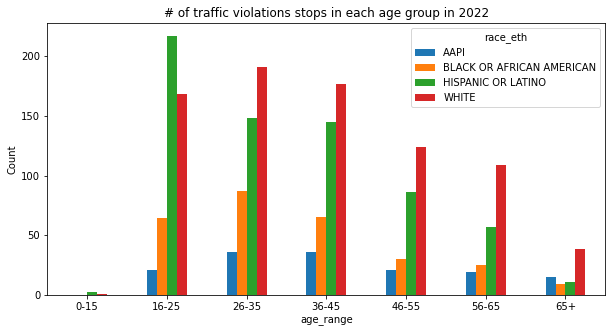

In [115]:
# Focusing on residents since that is the source of the finding about more frequent Black stops
year = 2022
tv_res = tv[tv["residency"]=="RESIDENT OF CITY/COUNTY OF STOP"]

by_age = tv_res[tv_res["year"]==year].groupby(["age_range","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()
by_age = by_age.drop(columns=["AMERICAN INDIAN OR ALASKA NATIVE","UNKNOWN"])
by_age = by_age.rename(columns={"ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER":"AAPI"})

by_age.plot.bar(figsize=[10,5], rot=0, title=f"# of traffic violations stops in each age group in {year}", ylabel="Count")

A higher percentage of young people are pulled over for traffic violations for Blacks and Latinos
This could result from a younger population, higher commission of traffic violations, and/or bias.
If you assume that the young population 16-25 largely matches the demographics of Herndon High School,
this can be evaluated a bit: https://schoolprofiles.fcps.edu/schlprfl/f?p=108:13:::NO::P0_CURRENT_SCHOOL_ID,P0_EDSL:270,0.
HHS has a larger Latino population (49.4%) than Herndon as a whole (36.7%).
However, the HHS Black population (6.7%) is about the same as Herndon (7.3%)


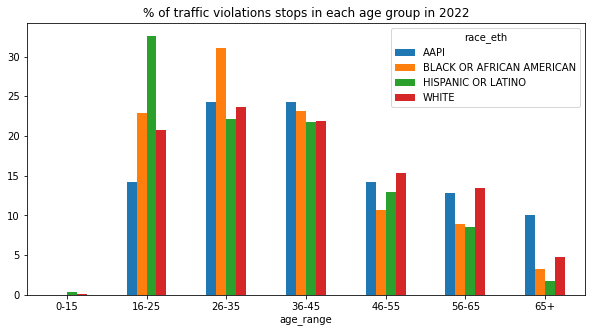

In [117]:
# Focusing on residents since that is the source of the finding about more frequent Black stops
year = 2022
by_age = tv_res[tv_res["year"]==year].groupby(["age_range","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()
by_age = round(by_age / by_age.sum() * 100, 1)
by_age = by_age.drop(columns=["AMERICAN INDIAN OR ALASKA NATIVE","UNKNOWN"])
by_age = by_age.rename(columns={"ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER":"AAPI"})

by_age.plot.bar(figsize=[10,5], rot=0, title=f"% of traffic violations stops in each age group in {year}")
ax.set_ylabel("%")

print("A higher percentage of young people are pulled over for traffic violations for Blacks and Latinos")
print("This could result from a younger population, higher commission of traffic violations, and/or bias.")
print("If you assume that the young population 16-25 largely matches the demographics of Herndon High School,")
print("this can be evaluated a bit: https://schoolprofiles.fcps.edu/schlprfl/f?p=108:13:::NO::P0_CURRENT_SCHOOL_ID,P0_EDSL:270,0.")
print("HHS has a larger Latino population (49.4%) than Herndon as a whole (36.7%).")
print("However, the HHS Black population (6.7%) is about the same as Herndon (7.3%)")

In [119]:
# There are very few 0-15 year olds
tmp = tv_res[tv_res["year"]==year].groupby(["race_eth","age_range"]).size().unstack("age_range").fillna(0).convert_dtypes().drop(columns="0-15")
total = tmp.sum()
tmp = tmp / total * 100

disprop = round(tmp.transpose() / pops,1).drop(columns=["UNKNOWN","AMERICAN INDIAN OR ALASKA NATIVE"])
disprop["COUNT"] = total

print("The below table shows the ratio of each race for each age group to that groups total (regardless of age) population in Herndon")
print("A value of 1 indicates that the % of people in group X for an age group is the same as their % population")
print("This is called disproportionality")
print("\nLatino disproportionality appears slightly high for the youngest age group but drops with age.")
print("White disproportionality increases with age")
print("Black disproportionality is highest for all age groups")
print("\nNote that since we are dealing with percentages, if one group is stopped less often, that will automatically boost the percentage of another groups")
print("Asians are stopped less often for most ages and older Latinos are rarely stopped")
disprop

The below table shows the ratio of each race for each age group to that groups total (regardless of age) population in Herndon
A value of 1 indicates that the % of people in group X for an age group is the same as their % population
This is called disproportionality

Latino disproportionality appears slightly high for the youngest age group but drops with age.
White disproportionality increases with age
Black disproportionality is highest for all age groups

Note that since we are dealing with percentages, if one group is stopped less often, that will automatically boost the percentage of another groups
Asians are stopped less often for most ages and older Latinos are rarely stopped


race_eth,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,WHITE,COUNT
age_range,,,,,
16-25,0.3,1.8,1.2,1.0,474
26-35,0.5,2.6,0.9,1.2,463
36-45,0.5,2.1,0.9,1.2,428
46-55,0.5,1.6,0.9,1.3,262
56-65,0.6,1.6,0.7,1.5,210
65+,1.3,1.7,0.4,1.5,73


In [120]:
print("To try to account for the underrepresentation of Asians and Latinos at certain ages. Let's normalize to the White disproportionality")
print("This is called disparity.")

print("\nBlack disparity is still high although unlike for disproportionality, it does decrease with age a bit more (mainly after 45).")
print("Let's focus on people under 45")

disprop.divide(disprop["WHITE"],axis=0).round(1)

To try to account for the underrepresentation of Asians and Latinos at certain ages. Let's normalize to the White disproportionality
This is called disparity.

Black disparity is still high although unlike for disproportionality, it does decrease with age a bit more (mainly after 45).
Let's focus on people under 45


race_eth,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,WHITE,COUNT
age_range,,,,,
16-25,0.3,1.8,1.2,1.0,474.0
26-35,0.4,2.2,0.8,1.0,385.8
36-45,0.4,1.8,0.8,1.0,356.7
46-55,0.4,1.2,0.7,1.0,201.5
56-65,0.4,1.1,0.5,1.0,140.0
65+,0.9,1.1,0.3,1.0,48.7


In [170]:
year = 2022
tv_u45 = tv_res[tv_res["age"].apply(lambda x: 16<=int(x)<=45)]
tv_u45 = tv_u45[tv_u45["year"]==year]

tmp = tv_u45.groupby(["action_taken","race_eth"]).size().unstack("race_eth").fillna(0).convert_dtypes()

print(f"Rates of different stop results for people under 45 in {year}")
print("\nBlacks are warned at a higher rate than whites but the same rate as other POC. ")
print("If we assume that POC are not more likely to warn when the officer would otherwise give a citation, this suggests that POC are either more likely to be pulled over\n for warnable/minor offenses and/or less likely to be pulled over for citable offenses")
print('Not sure that we have the fidelity to test this theory. We have information about the violation but it is pretty generic (i.e. data might say "speeding violation" not "speeding violation for being XX MPH over speed limit")')
round(tmp / tmp.sum()*100, 1)

Rates of different stop results for people under 45 in 2022

Blacks are warned at a higher rate than whites but the same rate as other POC. 
If we assume that POC are not more likely to warn when the officer would otherwise give a citation, this suggests that POC are either more likely to be pulled over
 for warnable/minor offenses and/or less likely to be pulled over for citable offenses
Not sure that we have the fidelity to test this theory. We have information about the violation but it is pretty generic (i.e. data might say "speeding violation" not "speeding violation for being XX MPH over speed limit")


race_eth,AMERICAN INDIAN OR ALASKA NATIVE,ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC OR LATINO,UNKNOWN,WHITE
action_taken,,,,,,
ARREST,0.0,0.0,0.5,1.2,0.0,0.0
CITATION/SUMMONS,66.7,63.4,64.8,63.7,25.0,71.8
NO ENFORCEMENT ACTION,0.0,1.1,0.0,0.6,0.0,0.0
WARNING ISSUED,33.3,35.5,34.7,34.5,75.0,28.2


In [185]:
tmp = tv_u45[(tv_u45["race_eth"].isin(["BLACK OR AFRICAN AMERICAN","WHITE"]))]

sort_vals = tmp[tmp["race_eth"].isin(["BLACK OR AFRICAN AMERICAN"])][["specific_violation","section_title"]].value_counts()

tmp = tmp[["specific_violation","section_title","action_taken","race_eth"]].value_counts(normalize=False).unstack("race_eth").fillna(0)
tmp=tmp.rename(columns={"BLACK OR AFRICAN AMERICAN":"BLACK %","WHITE":"WHITE %"})
total = tmp.sum()
tmp = tmp/total*100

tmp["BLACK TOTAL"] = (tmp["BLACK %"]/100 * total["BLACK %"]).fillna(0).astype(int)
tmp["WHITE TOTAL"] = (tmp["WHITE %"]/100 * total["WHITE %"]).fillna(0).astype(int)
tmp["TOTAL RATIO"] = tmp["BLACK TOTAL"] / tmp["WHITE TOTAL"]

# Sort by most common violations by Blacks regardless of result
new_index = []
for x in sort_vals.index:
    for result in ["CITATION/SUMMONS","WARNING ISSUED"]:
        y = (x[0], x[1], result)
        if y in tmp.index:
            new_index.append(y)

print(f"This shows the following for {year}:")
print("1. Percentage of Black/White stops for traffic violation ending in each violation and result. (46.2-830 for citations at 13.2% is % of all stops of Blacks not just citations)")
print("2. Total counts for each violation and result of stop for each group")
print("3. Ratio of Black Count to White Count\n")

print(f"Note that the number of cases gets pretty small quickly so those numbers may not have a lot of meaning. Thought about using data for all years but then we would have to deal with COVID effects on behavior\n")

print("Most notable is that when pulled over for 46.2-830 which I assume is mostly speeding, Blacks are given warnings about 1/2 the time while Whites are only given warnings about 1/3 of the time")

tmp.loc[new_index, :].head(15).round(1)

This shows the following for 2022:
1. Percentage of Black/White stops for traffic violation ending in each violation and result. (46.2-830 for citations at 13.2% is % of all stops of Blacks not just citations)
2. Total counts for each violation and result of stop for each group
3. Ratio of Black Count to White Count

Note that the number of cases gets pretty small quickly so those numbers may not have a lot of meaning. Thought about using data for all years but then we would have to deal with COVID effects on behavior

Most notable is that when pulled over for 46.2-830 which I assume is mostly speeding, Blacks are given warnings about half the time while Whites are only given warnings about 1/3 of the time


race_eth                                                                                                                                  BLACK %  \
specific_violation section_title                                                                                        action_taken                
46.2-830           Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcement... CITATION/SUMMONS     13.2   
                                                                                                                        WARNING ISSUED       12.7   
46.2-833           Traffic lights; penalty                                                                              CITATION/SUMMONS      5.9   
                                                                                                                        WARNING ISSUED        2.5   
46.2-646           Expiration and renewal of registration                                                               CITATION/SUMMONS      6.9   
                                                                                                                        WARNING ISSUED        1.0   
46.2-1158          Frequency of inspection; scope of inspection                                                         CITATION/SUMMONS      6.9   
                                                                                                                        WARNING ISSUED        0.0   
46.2-874           Maximum speed limit in business and residence districts                                              CITATION/SUMMONS      4.9   
                                                                                                                        WARNING ISSUED        1.5   
46.2-875           Maximum speed limit on certain other highways in cities and towns                                    CITATION/SUMMONS      3.4   
                                                                                                                        WARNING ISSUED        2.0   
46.2-821           Vehicles before entering certain highways shall stop or yield right-of-way                           CITATION/SUMMONS      1.5   
                                                                                                                        WARNING ISSUED        3.4   
46.2-818           Stopping vehicle of another; blocking access to premises; damaging or threatening commercial vehi... CITATION/SUMMONS      3.9   

race_eth                                                                                                                                  WHITE %  \
specific_violation section_title                                                                                        action_taken                
46.2-830           Uniform traffic control devices on highways; drivers to obey traffic control devices; enforcement... CITATION/SUMMONS     14.6   
                                                                                                                        WARNING ISSUED        7.9   
46.2-833           Traffic lights; penalty                                                                              CITATION/SUMMONS      3.2   
                                                                                                                        WARNING ISSUED        0.6   
46.2-646           Expiration and renewal of registration                                                               CITATION/SUMMONS      7.3   
                                                                                                                        WARNING ISSUED        2.0   
46.2-1158          Frequency of inspection; scope of inspection                                                         CITATION/SUMMONS      8.7   
                                                                                                                        WARNI